In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

In [260]:
obs_rf4_1_m25 = pd.read_csv("obs_rf4_1_m25.csv")

all_obs = [
    obs_rf4_1_m25,
]
all_labels = [
    'rf4_1_m25'
]

In [261]:
obs_rf4_1_m25.head()

,date,time,winner,num_horses,pool_size,scores,pools_i
0,2022-03-25,04:50 AM,3,5,112035,"{'1': 0.19885067059628517, '2': 0.199834390804...","{'1': 7553, '2': 19665, '3': 28220, '4': 5178}"
1,2022-03-25,02:00 PM,7,9,10201,"{'1': 0.11112048613499272, '2': 0.111111346772...","{'1': 1314, '2': 1010, '3': 1604, '4': 1846, '..."
2,2022-03-25,04:16 PM,6,7,27249,"{'1': 0.14302491492877278, '3': 0.142952981057...","{'1': 4534, '2': 0, '3': 5621, '4': 795, '5': ..."
3,2022-03-25,04:27 PM,9,8,11596,"{'1': 0.12497820263390509, '4': 0.124968898569...","{'1': 1626, '2': 0, '3': 0, '4': 413, '5': 545..."
4,2022-03-25,01:15 PM,2,6,44808,"{'1': 0.16465976188132286, '2': 0.164296812517...","{'1': 7202, '2': 2687, '3': 4770, '4': 26225, ..."


In [262]:
def add_cols(df):
    if 'date' in df.columns and 'time' in df.columns:
        df['datetime'] = (df['date'] + ' ' + df['time']).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %I:%M %p'))
        df.drop(['date','time'], axis=1, inplace=True)
    
for ob in all_obs:
    add_cols(ob)

## Returns based on number of horses in a race

* scores: winning probabilities (p)
* pool_size: total money in the pool (omega)
* pools_i: money in the pool for a specific horse (h0)
* s: remaining pool after takeaway (s). estimate this to be something.

Use gradient descent to find the expected return for each horse. Using the same GD, find the optimal bet size for each horse.

expected return `E[r] = b*(s*(pool+b)/(h0+b) - 1)*p + (1-p)*-b`

`dr = dr = -(s*pool*p+2*s*p*b)/(h0+b) + (s*pool*b*p+s*p*(b**2))/((h0+b)**2) + 1`

In [263]:
def extract_dict(row, col_name):
    return json.loads(row.replace("\'", "\""))
def get_scores(df):
    return df['scores'].apply(lambda x: extract_dict(x, 'scores'))
def get_pools_i(df):
    return df['pools_i'].apply(lambda x: extract_dict(x, 'pools_i'))

def size_bet_odds(pool, s, p, h0, lr=10, precision=0.1, max_iters=10000):
    b = 0
    iters = 0
    prev_step_size = 1
    
    while iters < max_iters and prev_step_size > precision:
        dr = -(s*pool*p+2*s*p*b)/(h0+b) + (s*pool*b*p+s*p*(b**2))/((h0+b)**2) + 1
        prev_b = b
        b = b - lr*dr
        prev_step_size = abs(b-prev_b)
        iters += 1
    if iters >= max_iters:
        pass
    return b, s*(pool+b)/(h0+b)-1

def sim(df, money, verbose=False):
    ps = []
    # for each race j,
    results = []
    returns = []
    for j in range(df.shape[0]):
        s = 0.8
        pool = df['pool_size'][j]
        
        # for each horse in the race,
        # get scores and pools_i. may need to combine the keys in scores to match pools_i.
        # calculate the expected return and optimal bet size.
        scores = get_scores(df)
        pools_i = get_pools_i(df)
        
        if verbose:
            print(f'race {j}:')
        
        positive_horse_pEr_list = []
        for k,v in scores[j].items():
            # get p = v
            # remove the letter, if it exists. get h0 = pools_i[the remaining number]
            p = v
            pool_category = k if len(k) == 1 and k[-1].isdigit() else pools_i[j][k[:-1]]
            if pool_category not in pools_i[j].keys():
                continue
    
            h0 = pools_i[j][pool_category]
            b, odds = size_bet_odds(pool, s, p, h0)
            b = min(max(b, 0), money[-1]/10)
            Er = odds*b*p - b*(1-p)
            if b != 0:
                pEr = Er/b # expected percent return
                if pEr > 0:
                    positive_horse_pEr_list.append([pEr, b, Er, k])
        
        sorted_list = sorted(positive_horse_pEr_list, key=lambda x: -x[0])
        if sorted_list:
            pEr, b, Er, choice = sorted_list[0]
            
            winner = str(df['winner'][j])
            
            if choice == winner:
                results.append(1)
                returns.append(Er)
                if verbose:
                    print(f'  Won {Er}. b: {b}, odds: {odds}, p_hat: {p}.')
                money.append(money[-1] + Er)
            else:
                results.append(0)
                returns.append(-b)
                if verbose:
                    print(f'  Lost {b}. b: {b}, odds: {odds}, p_hat: {p}.')
                money.append(money[-1] - b)
        else:
            money.append(money[-1])
    print(f'winrate: {np.average(results)}')  
    plt.hist(returns)
    plt.show()

winrate: 0.04827586206896552


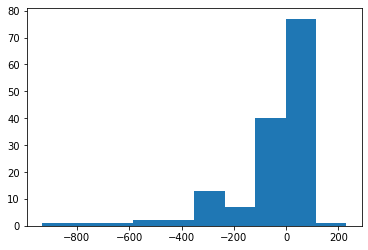

In [264]:
obs_rf4_1_m25 = obs_rf4_1_m25.sort_values('datetime').reset_index(drop=True)
money=[10000]
sim(obs_rf4_1_m25, money, verbose=False)

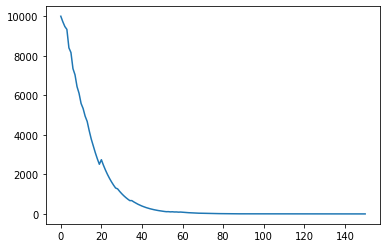

In [265]:
plt.plot(money)

In [39]:

def sim_plot(df, p):

    money = [1000]
    sim(df, money, p=p)

    plt.figure(figsize=(20,3))
    plt.ylabel('cash')
    plt.xlabel('# horse bets')
    plt.grid()
    plt.plot(df['datetime'], np.average(runs, axis=0)[1:])
    plt.show()
    
#######################

def get_scores(df):
    def get_race_scores(scores_str):
        return json.loads(('{'+obs_rf4_1_m25['scores'][0].split('{')[1][:-1]).replace("\'", "\""))
#     def get_scores_row(scores_str):
#         return np.array([float(x) for x in scores_str[1:-1].split(' ') if x != ''])
    return df['scores'].apply(lambda x: get_race_scores(x))

def plot_expected_return_by_num_horses(dfs, labels):
    x_low, x_high = 4, 13
    offset = 2 # least number of horses in a race. get this from the histogram above
    
    for df, label in zip(dfs, labels):
        scores = get_scores_matrix(df)
#         if len(scores[i]) != df['num_horses']
        for i in range(df.shape[0]):
            np.dot(scores[i].T, )
        returns = df.groupby(['num_horses']).mean()
        plt.plot(returns.index[x_low-offset:x_high-offset], returns['confidence'][x_low-offset:x_high-offset], label=label)
    plt.title('confidence by number of horses')
    plt.xticks(range(x_low,x_high))
    plt.xlabel('number of horses in the race')
    plt.ylabel('confidence')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_confidence_by_num_horses(all_obs, all_labels)

NameError: name 'plot_confidence_by_num_horses' is not defined